In [1]:
%config IPCompleter.greedy=True

# Imports
import os
import warnings
import tools
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Bidirectional
from matplotlib import pyplot

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Root CSV files directory
dirname = "./data/"

# Constant frame count.
frames = 100

listfile = os.listdir(dirname)
data = []
for wordname in listfile:
    if wordname == ".DS_Store":
        continue
    for csv in os.listdir(dirname + wordname):
        filepath = os.path.join(dirname, wordname, csv)
        content = pd.read_csv(filepath, sep=';')
        content = content.reindex(list(range(0, frames)), fill_value=0.0)
        content.fillna(0.0, inplace = True) 
        data.append((wordname, content))
        
features = [n[1] for n in data]
features = [f.to_numpy() for f in features]
labels = [n[0] for n in data]
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.40, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.50, random_state=42)


tokenizer = tools.tokenize(dirname)
print(tokenizer.word_index)
encoded_train=tokenizer.texts_to_sequences([y_train])[0]
encoded_val=tokenizer.texts_to_sequences([y_val])[0]
encoded_test=tokenizer.texts_to_sequences([y_test])[0]
y_train = to_categorical(encoded_train)
y_val = to_categorical(encoded_val)
y_test = to_categorical(encoded_test)

# Making numpy arrays
x_train=np.array(x_train)
y_train=np.array(y_train)
x_val=np.array(x_val)
y_val=np.array(y_val)
x_test=np.array(x_test)
y_test=np.array(y_test)


{'computer': 1, 'deutschland': 2, 'hallo': 3, 'welt': 4}


In [3]:
def build_model(hp):
    model = Sequential()
    
    model.add(layers.LSTM(hp.Int("LSTM_input", min_value =32, max_value=256,step=32), 
                            return_sequences=True,
                            input_shape=(x_train.shape[1], x_train.shape[2])))
    
    for i in range(hp.Int("n_layers" , 1, 4)):    
        model.add(layers.LSTM(hp.Int(f"LSTM_{i}_units", min_value =32, max_value=256,step=32),
                                return_sequences=True))
    
    model.add(layers.LSTM(hp.Int(f"LSTM_End", min_value =32, max_value=256,step=32)))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    model.summary()
    return model


## Alternative 1
Reload a Keras-Tuner LOG_DIR.... For this, the Tuner has to instantiated exactly like in the learning phase. LOG_DIR currently not included


In [ ]:
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

tuner  = Hyperband(
    build_model,
    objective = "val_accuracy",
    max_epochs=90,    
    directory = ".\Optimization_2020_04_07_121150",
    project_name='SignLagnuageModelOptimization'
    )

tuner.reload() 



In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
model= tuner.hypermodel.build(best_hp)

history = model.fit(x_train,y_train,epochs=80,batch_size=32,validation_data=(x_val,y_val),shuffle=False)


## Alternative 2
Load Pickle object from learning/searching phase

In [4]:



import pickle

tuner2= pickle.load(open("tuner_2020_04_07_121150.pkl", "rb"))
best_hp2= tuner2.get_best_hyperparameters()[0]
model2= tuner2.hypermodel.build(best_hp2)

history2 = model2.fit(x_train,y_train,epochs=80,batch_size=32,validation_data=(x_val,y_val),shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          351232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           82176     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 499,781
Trainable params: 499,781
Non-trainable params: 0
_________________________________________________________________
Train on 208 samples, validate on 69 samples
Epoch 1/80
208/208 [==============================] - ETA: 31s - loss: 

208/208 [==============================] - ETA: 1s - loss: 0.7579 - accuracy: 0.7500 - precision: 0.8667 - recall: 0.406 - ETA: 1s - loss: 0.7841 - accuracy: 0.6562 - precision: 0.6889 - recall: 0.484 - ETA: 1s - loss: 0.8237 - accuracy: 0.6354 - precision: 0.7321 - recall: 0.427 - ETA: 0s - loss: 0.8357 - accuracy: 0.6094 - precision: 0.7313 - recall: 0.382 - ETA: 0s - loss: 0.8784 - accuracy: 0.6000 - precision: 0.6889 - recall: 0.387 - ETA: 0s - loss: 0.8833 - accuracy: 0.5990 - precision: 0.7100 - recall: 0.369 - 2s 11ms/sample - loss: 0.8881 - accuracy: 0.5817 - precision: 0.7184 - recall: 0.3558 - val_loss: 0.8554 - val_accuracy: 0.6087 - val_precision: 0.8710 - val_recall: 0.3913
Epoch 12/80
208/208 [==============================] - ETA: 1s - loss: 0.6968 - accuracy: 0.7812 - precision: 0.8333 - recall: 0.312 - ETA: 1s - loss: 0.7575 - accuracy: 0.6719 - precision: 0.6512 - recall: 0.437 - ETA: 1s - loss: 0.7993 - accuracy: 0.6458 - precision: 0.6909 - recall: 0.395 - ETA: 0s -

208/208 [==============================] - ETA: 1s - loss: 0.5940 - accuracy: 0.7812 - precision: 0.8065 - recall: 0.781 - ETA: 1s - loss: 0.5716 - accuracy: 0.7812 - precision: 0.8000 - recall: 0.750 - ETA: 0s - loss: 0.6155 - accuracy: 0.7708 - precision: 0.7753 - recall: 0.718 - ETA: 0s - loss: 0.6575 - accuracy: 0.7344 - precision: 0.7355 - recall: 0.695 - ETA: 0s - loss: 0.6840 - accuracy: 0.7375 - precision: 0.7351 - recall: 0.693 - ETA: 0s - loss: 0.6882 - accuracy: 0.7448 - precision: 0.7444 - recall: 0.697 - 2s 10ms/sample - loss: 0.6675 - accuracy: 0.7596 - precision: 0.7602 - recall: 0.7163 - val_loss: 0.7175 - val_accuracy: 0.7681 - val_precision: 0.7681 - val_recall: 0.7681
Epoch 23/80
208/208 [==============================] - ETA: 1s - loss: 0.6177 - accuracy: 0.7812 - precision: 0.7812 - recall: 0.781 - ETA: 1s - loss: 0.5699 - accuracy: 0.7969 - precision: 0.7937 - recall: 0.781 - ETA: 1s - loss: 0.6644 - accuracy: 0.7188 - precision: 0.7234 - recall: 0.708 - ETA: 0s -

208/208 [==============================] - ETA: 1s - loss: 0.8486 - accuracy: 0.6250 - precision: 0.8750 - recall: 0.437 - ETA: 1s - loss: 0.7134 - accuracy: 0.6406 - precision: 0.7391 - recall: 0.531 - ETA: 1s - loss: 0.6961 - accuracy: 0.6771 - precision: 0.7761 - recall: 0.541 - ETA: 0s - loss: 0.7835 - accuracy: 0.6406 - precision: 0.7222 - recall: 0.507 - ETA: 0s - loss: 0.7865 - accuracy: 0.6375 - precision: 0.7025 - recall: 0.531 - ETA: 0s - loss: 0.7707 - accuracy: 0.6667 - precision: 0.7203 - recall: 0.536 - 3s 13ms/sample - loss: 0.7497 - accuracy: 0.6827 - precision: 0.7372 - recall: 0.5529 - val_loss: 0.7328 - val_accuracy: 0.6377 - val_precision: 0.6471 - val_recall: 0.6377
Epoch 34/80
208/208 [==============================] - ETA: 1s - loss: 0.5026 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.812 - ETA: 1s - loss: 0.5107 - accuracy: 0.7500 - precision: 0.7931 - recall: 0.718 - ETA: 1s - loss: 0.5285 - accuracy: 0.7917 - precision: 0.8222 - recall: 0.770 - ETA: 0s -

208/208 [==============================] - ETA: 1s - loss: 0.6035 - accuracy: 0.7812 - precision: 0.7812 - recall: 0.781 - ETA: 1s - loss: 0.5835 - accuracy: 0.7188 - precision: 0.7258 - recall: 0.703 - ETA: 1s - loss: 0.5986 - accuracy: 0.6979 - precision: 0.7531 - recall: 0.635 - ETA: 0s - loss: 0.6142 - accuracy: 0.6875 - precision: 0.7800 - recall: 0.609 - ETA: 0s - loss: 0.6296 - accuracy: 0.7000 - precision: 0.8000 - recall: 0.600 - ETA: 0s - loss: 0.6493 - accuracy: 0.6979 - precision: 0.8014 - recall: 0.609 - 2s 12ms/sample - loss: 0.6327 - accuracy: 0.7115 - precision: 0.8086 - recall: 0.6298 - val_loss: 0.9613 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 45/80
208/208 [==============================] - ETA: 1s - loss: 0.9026 - accuracy: 0.7188 - precision: 0.7188 - recall: 0.718 - ETA: 1s - loss: 0.8835 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.687 - ETA: 1s - loss: 0.8149 - accuracy: 0.6979 - precision: 0.6979 - recall: 0.697 - ETA: 0s -

208/208 [==============================] - ETA: 1s - loss: 0.3625 - accuracy: 0.8750 - precision: 0.9032 - recall: 0.875 - ETA: 1s - loss: 0.3501 - accuracy: 0.8594 - precision: 0.8871 - recall: 0.859 - ETA: 1s - loss: 0.3373 - accuracy: 0.8646 - precision: 0.8830 - recall: 0.864 - ETA: 0s - loss: 0.3616 - accuracy: 0.8594 - precision: 0.8730 - recall: 0.859 - ETA: 0s - loss: 0.4021 - accuracy: 0.8500 - precision: 0.8662 - recall: 0.850 - ETA: 0s - loss: 0.4076 - accuracy: 0.8542 - precision: 0.8677 - recall: 0.854 - 2s 12ms/sample - loss: 0.3876 - accuracy: 0.8654 - precision: 0.8780 - recall: 0.8654 - val_loss: 0.4902 - val_accuracy: 0.8986 - val_precision: 0.8986 - val_recall: 0.8986
Epoch 56/80
208/208 [==============================] - ETA: 1s - loss: 0.5562 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.843 - ETA: 1s - loss: 0.3833 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.890 - ETA: 1s - loss: 0.3316 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.906 - ETA: 0s -

208/208 [==============================] - ETA: 1s - loss: 0.3637 - accuracy: 0.9062 - precision: 0.9310 - recall: 0.843 - ETA: 1s - loss: 0.4564 - accuracy: 0.8438 - precision: 0.8525 - recall: 0.812 - ETA: 1s - loss: 0.4433 - accuracy: 0.8438 - precision: 0.8495 - recall: 0.822 - ETA: 0s - loss: 0.4536 - accuracy: 0.8359 - precision: 0.8468 - recall: 0.820 - ETA: 0s - loss: 0.4958 - accuracy: 0.8188 - precision: 0.8269 - recall: 0.806 - ETA: 0s - loss: 0.5280 - accuracy: 0.8125 - precision: 0.8191 - recall: 0.802 - 2s 11ms/sample - loss: 0.5140 - accuracy: 0.8125 - precision: 0.8186 - recall: 0.8029 - val_loss: 0.6282 - val_accuracy: 0.7971 - val_precision: 0.9111 - val_recall: 0.5942
Epoch 67/80
208/208 [==============================] - ETA: 1s - loss: 0.4255 - accuracy: 0.8438 - precision: 0.9231 - recall: 0.750 - ETA: 1s - loss: 0.3723 - accuracy: 0.8750 - precision: 0.9138 - recall: 0.828 - ETA: 1s - loss: 0.4131 - accuracy: 0.8333 - precision: 0.8556 - recall: 0.802 - ETA: 0s -

208/208 [==============================] - ETA: 1s - loss: 0.5020 - accuracy: 0.8438 - precision: 0.8438 - recall: 0.843 - ETA: 1s - loss: 0.5217 - accuracy: 0.7812 - precision: 0.7812 - recall: 0.781 - ETA: 1s - loss: 0.4335 - accuracy: 0.8333 - precision: 0.8387 - recall: 0.812 - ETA: 0s - loss: 0.4473 - accuracy: 0.8359 - precision: 0.8400 - recall: 0.820 - ETA: 0s - loss: 0.4570 - accuracy: 0.8375 - precision: 0.8408 - recall: 0.825 - ETA: 0s - loss: 0.4863 - accuracy: 0.8281 - precision: 0.8351 - recall: 0.817 - 2s 10ms/sample - loss: 0.4650 - accuracy: 0.8413 - precision: 0.8458 - recall: 0.8173 - val_loss: 0.5151 - val_accuracy: 0.8406 - val_precision: 0.8529 - val_recall: 0.8406
Epoch 78/80
208/208 [==============================] - ETA: 1s - loss: 0.6521 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.812 - ETA: 1s - loss: 0.4785 - accuracy: 0.8438 - precision: 0.8413 - recall: 0.828 - ETA: 1s - loss: 0.3988 - accuracy: 0.8854 - precision: 0.8842 - recall: 0.875 - ETA: 0s -

NameError: name 'history' is not defined

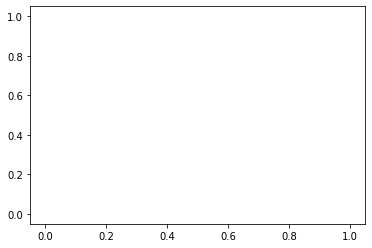

In [5]:
pyplot.autoscale(enable=True, axis='both', tight=None)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.autoscale(enable=True, axis='both', tight=None)
pyplot.plot(history2.history['loss'])
pyplot.plot(history2.history['val_loss'])
pyplot.title('model train vs validation loss 2')
pyplot.ylabel('loss2')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.autoscale(enable=True, axis='both', tight=None)
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

pyplot.autoscale(enable=True, axis='both', tight=None)
pyplot.plot(history2.history['accuracy'])
pyplot.plot(history2.history['val_accuracy'])
pyplot.title('model train vs validation accuracy 2')
pyplot.ylabel('accuracy2')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

# Underfit Example
Running this example produces a plot of train and validation loss showing the characteristic of an underfit model. In this case, performance may be improved by increasing the number of training epochs.


<img src="assets/Diagnostic-Line-Plot-Showing-an-Underfit-Model.png" width="400">


Running this example shows the characteristic of an underfit model that appears under-provisioned.
In this case, performance may be improved by increasing the capacity of the model, such as the number of memory cells in a hidden layer or number of hidden layers.

<img src="assets/Diagnostic-Line-Plot-Showing-an-Underfit-Model-via-Status.png" width="400">

#### Good Fit Example
Running the example creates a line plot showing the train and validation loss meeting.
Ideally, we would like to see model performance like this if possible, although this may not be possible on challenging problems with a lot of data.

<img src="assets/Diagnostic-Line-Plot-Showing-a-Good-Fit-for-a-Model.png" width="400">

#### Overfit Example
Running this example creates a plot showing the characteristic inflection point in validation loss of an overfit model.
This may be a sign of too many training epochs.
In this case, the model training could be stopped at the inflection point. Alternately, the number of training examples could be increased.

<img src="assets/Diagnostic-Line-Plot-Showing-an-Overfit-Model.png" width="400">

### Evaluate

In [8]:
#model.evaluate(x_test, y_test, verbose=2)
model2.evaluate(x_test, y_test, verbose=2)

70/70 - 0s - loss: 0.6031 - accuracy: 0.8000 - precision: 0.8000 - recall: 0.8000


[0.6031400093010494, 0.8, 0.8, 0.8]

### Save model

In [ ]:
model.save("sign_lang_recognition_tuned.h5")